# Projet phylogénétique
Théophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présent dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant faites attention au plagiat !

Le projet est à rendre **en binôme** par mail avant le **22/04**. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [10]:
# À remplir
def fasta_parser(file_name):
    data = {}
    with open(file_name, 'r') as f:
        content = f.read()
#         print (str(content))
        blocks = content.split('>')
#         print (blocks)
        for block in blocks:
            lines = block.splitlines()
#             print(lines)
            if len(lines)>2:
                data[lines[0]]= ''.join(lines[1:])
    return data

In [3]:
fasta_parser('cat_dna.fasta')

{'African wild cat DNA': 'CTTATCAAAATTATTAATCACTCATTCATCGATCTACCCGCCCCATCTAACATCTCAGCATGATGAAACTTCGGCTCCCTTCTAGGAGTCTGCCTAATCTTACAAATCCTCACCGGCCTCTTTTTGGCCATACACTACACATCAGACACAATAACCGCCTTTTCATCAGTTACCCACATCTGTCGCGACGTTAATTATGGCTGAATCATCCAGATATTTACACGCCAACGGAGCTTCTATATTCTTTATCTGCCTGTACATACACGTAGGACGGGGAATATACTAC',
 'American Cat DNA': 'CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTACTAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATACACTACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTATATACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGGAATATATTAC',
 'Black Bear DNA': 'TTAGCTAAAATCATCAACAACTCACTCATTGATCTCCCAGCACCATCAAATATCTCAGCATGATGAAACTTCGGGTCCCTCCTCGGAGTATGTTTAGTACTACAAATTCTAACGGGCCTATTCCTAGCTATACACTATACATCAGACACAACTACAGCCTTTTCATCAATCACCCATATTTGCCGAGATGTTCACTACGGATGAATTATCCGATACATACATGCTAACGGAGCTTCCATATTCTTTATCTGCCTGTTCATGCACGTAGGACGGGGTCTGTACTAT',
 'Brown Bear DNA': 'TTAGCTAAAATCATCAACAACTCATTTATTGACCTTCCAACACCATC

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 3 substitutions
- l'alignement 2 implique au minimum 1 indel et 2 substitutions
- l'alignement 3 implique au minimum 1 indel et 3 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|       | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|       | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | -5 |

**Exercice 2 : ** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [8]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
    def sequence_score(self, seq1, seq2):
        score = 0.0
        for letter1, letter2 in zip(seq1,seq2):
            score+= self.score(letter1, letter2)
        return score
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [165]:
# À remplir
print('Score A1:', similarity_matrix.sequence_score('-ACTCCTGA','ATCTCGTGA'))
print('Score A2:', similarity_matrix.sequence_score('A-CTCCTGA','ATCTCGTGA'))
print('Score A3:', similarity_matrix.sequence_score('AC-TCCTGA','ATCTCGTGA'))

Score A1: 35.0
Score A2: 49.0
Score A3: 39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $n \times m$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|       | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 |   |   |   |   |   |   |   |   |   |
| **C** |-10|   |   |   |   |   |   |   |   |   |
| **T** |-15|   |   |   |   |   |   |   |   |   |
| **C** |-20|   |   |   |   |   |   |   |   |   |
| **C** |-25|   |   |   |   |   |   |   |   |   |
| **T** |-30|   |   |   |   |   |   |   |   |   |
| **G** |-45|   |   |   |   |   |   |   |   |   |
| **A** |-40|   |   |   |   |   |   |   |   |   ||

Puis on initialise $T$ :

|       | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u |   |   |   |   |   |   |   |   |   |
| **C** | u |   |   |   |   |   |   |   |   |   |
| **T** | u |   |   |   |   |   |   |   |   |   |
| **C** | u |   |   |   |   |   |   |   |   |   |
| **C** | u |   |   |   |   |   |   |   |   |   |
| **T** | u |   |   |   |   |   |   |   |   |   |
| **G** | u |   |   |   |   |   |   |   |   |   |
| **A** | u |   |   |   |   |   |   |   |   |   ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n}$, $j \in {2, \dots, m}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|       | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|       | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|       | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o |   |   |   |   |   |   |   |   |   |
| **A** |   | d | l |   |   |   |   |   |   |   |
| **C** |   |   |   | d |   |   |   |   |   |   |
| **T** |   |   |   |   | d |   |   |   |   |   |
| **C** |   |   |   |   |   | d |   |   |   |   |
| **C** |   |   |   |   |   |   | d |   |   |   |
| **T** |   |   |   |   |   |   |   | d |   |   |
| **G** |   |   |   |   |   |   |   |   | d |   |
| **A** |   |   |   |   |   |   |   |   |   | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [5]:
class NeedlmanWunsch:
    def __init__(self, seq1, seq2, similarity_matrix):
        self.seq1 = "-"+seq1
        self.seq2 = "-"+seq2
        self.s_matrix = similarity_matrix
        
        self.n = len(self.seq1)
        self.m = len(self.seq2)
        self.M = np.zeros((self.n,self.m))
        self.T = np.chararray((self.n,self.m))
        self.T[:] = ''
        self.T[:,0] = 'u'
        self.T[0,:] = 'l'
        self.T[0,0] = 'o'
        
        self.M[0,0] = 0
        
        for i in range(1,self.n):
            self.M[i,0] = self.M[i-1,0] + self.s_matrix.score(self.seq1[i], self.seq2[0])
        for i in range(1,self.m):
            self.M[0,i] = self.M[0,i-1] + self.s_matrix.score(self.seq1[0], self.seq2[i])
        
        for i in range(1,self.n):
            for j in range(1,self.m):
                val =  max([self.M[i-1,j-1]+self.s_matrix.score(self.seq1[i], self.seq2[j]),0],
                       [self.M[i,j-1]+self.s_matrix.score(self.seq1[i], "-"),1],
                       [self.M[i-1,j]+self.s_matrix.score(self.seq2[j], "-"),2],key=lambda e: e[0])
                self.M[i,j] = val[0]
                self.T[i,j] = ['d','l','u'][val[1]]
    
  
    def getM(self):
        return self.M
    def getT(self):
        return self.T
    def get_score(self):
        return self.M[self.n-1,self.m-1]
    
    def switch(self,a,i,j):
        return {
            b'd':(self.seq1[i],self.seq2[j], i-1,j-1),
            b'l':('-',self.seq2[j], i,j-1),
            b'u':(self.seq1[i],'-', i-1,j)
        }[a]
    
    def get_seq(self):
        i = self.n -1
        j = self.m - 1
        A = ''
        B = ''
        while((i>0) or (j>0)):
#             print(i,j)
            a,b,i,j = self.switch(self.T[i,j],i,j)
            A = a+A
            B = b+B
        return (A,B)
    

In [167]:
needlman = NeedlmanWunsch('ACTCCTGA','ATCTCGTGA',similarity_matrix)

In [8]:
needlman.getM()

array([[  0.,  -5., -10., -15., -20., -25., -30., -35., -40., -45.],
       [ -5.,  10.,   5.,   0.,  -5., -10., -15., -20., -25., -30.],
       [-10.,   5.,   7.,  12.,   7.,   2.,  -3.,  -8., -13., -18.],
       [-15.,   0.,  13.,   8.,  20.,  15.,  10.,   5.,   0.,  -5.],
       [-20.,  -5.,   8.,  20.,  15.,  27.,  22.,  17.,  12.,   7.],
       [-25., -10.,   3.,  15.,  17.,  22.,  22.,  19.,  14.,  11.],
       [-30., -15.,  -2.,  10.,  23.,  18.,  22.,  30.,  25.,  20.],
       [-35., -20.,  -7.,   5.,  18.,  18.,  27.,  25.,  39.,  34.],
       [-40., -25., -12.,   0.,  13.,  17.,  22.,  23.,  34.,  49.]])

In [9]:
needlman.getT()

chararray([['o', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l'],
           ['u', 'd', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'd'],
           ['u', 'u', 'd', 'd', 'l', 'd', 'l', 'l', 'l', 'l'],
           ['u', 'u', 'd', 'l', 'd', 'l', 'l', 'd', 'l', 'l'],
           ['u', 'u', 'u', 'd', 'l', 'd', 'l', 'l', 'l', 'l'],
           ['u', 'u', 'u', 'd', 'd', 'd', 'd', 'd', 'l', 'd'],
           ['u', 'u', 'd', 'u', 'd', 'l', 'd', 'd', 'l', 'l'],
           ['u', 'u', 'u', 'u', 'u', 'd', 'd', 'u', 'd', 'l'],
           ['u', 'd', 'u', 'u', 'u', 'd', 'u', 'd', 'u', 'd']],
          dtype='|S1')

In [10]:
needlman.get_seq()

('A-CTCCTGA', 'ATCTCGTGA')

----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [85]:
def distMatrix(sps):
    keys = list(sps.keys())
    matrix = [[0.0 for a in keys] for b in keys]
    for i in range(1,len(keys)):
        sp = keys[i]
        for j in range(0,i):
            sp2 = keys[j]
            needlman = NeedlmanWunsch(sps[sp],sps[sp2],similarity_matrix)
            seq = needlman.get_seq()
            dist = 1.- np.sum([ 1. for a,b in zip(seq[0],seq[1]) if a==b])/len([1. for a,b in zip(seq[0],seq[1]) if a!='-' and b!='-'])
            matrix[i][j] = dist
    return matrix,keys

In [199]:
distMatrix({'a':'ACTCCTGA','b': 'ATCTCGTGA'})

['a', 'b']
[[0.0, 0.0], [0.0, 0.0]]
1 0


([[0.0, 0.0], [0.125, 0.0]], ['a', 'b'])

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui malgré son nom compliqué est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

In [1]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:0.2,(B:0.2,C:0.3):0.5):0.5,D:0.4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True

In [ ]:
from IPython.display import display
display(t.render('%%inline', w=183, units='mm', tree_style=ts))

**Exercice 5 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

In [221]:
newick_tree = "((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2):0;"

In [220]:
newick_tree = '((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2):0;'

t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True

NameError: name 'Tree' is not defined

##### Autre Methode

In [22]:
from Bio import Phylo
from io import StringIO

In [223]:
handle = StringIO(newick_tree)
tree = Phylo.read(handle, "newick")

In [224]:
print(tree)

Tree(rooted=False, weight=1.0)
    Clade(branch_length=0.0)
        Clade(branch_length=5.0)
            Clade(branch_length=10.0, name='A')
            Clade(branch_length=8.0, name='B')
            Clade(branch_length=7.0, name='C')
        Clade(branch_length=2.0)
            Clade(branch_length=9.0, name='D')
            Clade(branch_length=2.0)
                Clade(branch_length=5.0, name='E')
                Clade(branch_length=5.0, name='F')


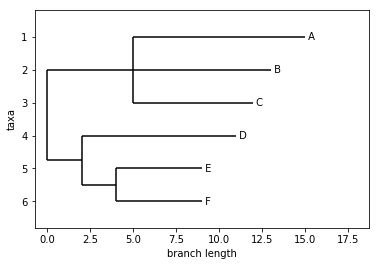

In [225]:
Phylo.draw(tree,show_confidence=True)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Pourquoi cet arbre n'est pas réaliste ? Donnez une réponse détaillée.

Réponse : I'll on't le meme encetre commen "cousin". <br/>
il n'est pas resolus, parce que A,B et C aparait d'evoluer les trois en meme temp ce qui n'est pas realiste.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|       | A | B | C | D |
|   -   | - | - | - | - |
| **A** |   |   |   |   |
| **B** | 2 |   |   |   |
| **C** | 4 | 6 |   |   |
| **D** | 1 | 2 | 4 |   |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=1$). On les regroupe et on met à jour la matrice :

|       | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** |   |   |   |
| **B** | 2 |   |   |
| **C** | 4 | 6 |   ||

On regroupe maintenant $(A,D)$ et $B$ (distance((A,D),B) = 2) :

|       | ((A, D), B) | C |
|   -   | - | - | - |
| **((A, D), B)** |   |   |   |
| **C** | 4,67 |   ||

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (4*2 + 6) \mathbin{/} 3 = 4,67 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:0.5, D:0.5):0.5, B:1):1.335, C:2.335);$ 

**Exercice 7 :** Implémenter l'algorithme qui permet de calculer l'arbre UPGMA au format Newick **sans les distances** à partir d'une matrice de distance.

In [76]:
import math
import numpy as np
class UPGMA:
    def __init__(self, d_matrix, keys):
        self.D = d_matrix
        self.keys = keys
        self.keys_len = {}
        for sp in keys:
            self.keys_len[sp] = 1.
        self.list_D = [(self.D,self.keys)]
    
    def join(self,l):
        
            if not isinstance(l, list):
                return l
            ret = ''
            for i in l:
                if isinstance(i, list):
                    ret+=","+self.join(i)
                else:
                    ret+=","+i
#             print (ret)
            return "({})".format(ret[1:])
    
    def iterate(self,new_d,new_k):
#             print (new_d,new_k)
            if(len(new_d) < 3):
                return new_d,new_k
            
            keys_to_id = dict(zip([self.join(k) for k in new_k],range(len(new_k))))
            
            min_d, min_d_id = float('inf') ,(0,0)
            for i in range(1,len(new_d)):
                for j in range(0,i):
                    if new_d[i,j] < min_d:
                        min_d, min_d_id = new_d[i,j],(i,j)
            (i,j) = min_d_id
            
#             print (len(new_k),len(new_d))
#             print (new_k)
            temp_k = [[new_k[i],new_k[j]]] 
            temp_k += [new_k[k] for k in range(len(new_k)) if k != i and k != j]
            temp_d = np.zeros((len(temp_k),len(temp_k)),dtype=np.float32)
            
            ni = len(new_k[i])
            nj = len(new_k[j])
            
            for k in range(1,len(temp_k)):
                k2 = keys_to_id[self.join(temp_k[k])]
                di = (ni*new_d[max(i,k2),min(i,k2)])
                dj = (nj*new_d[max(j,k2), min(j,k2)])
                temp_d[k][0] = (di + dj)/float(ni+nj)
                
#                 print (ni,nj,di,dj)
            for i in range(1,len(temp_k)):
                for j in range(1,i):
                    temp_d[i][j] = new_d[keys_to_id[self.join(temp_k[i])],keys_to_id[self.join(temp_k[j])]]
#             print(self.join(temp_k))
            return  self.iterate(temp_d, temp_k)
    def compute(self):
            return self.join(self.iterate(self.D,self.keys)[1])
        
        

In [77]:
keys = ['A','B','C','D'] 
d_matrix = np.array([[0.0,0.0,0.0,0.0],[2.0,0.0,0.0,0.0],[4.0,6.0,0.0,0.0],[1.0,2.0,4.0,0.0]])

In [78]:
upgma = UPGMA(d_matrix,keys)

In [79]:
upgma.compute()

'((B,(D,A)),C)'

In [72]:
upgma.iterate(d_matrix,keys)

(array([[0.       , 0.       ],
        [4.6666665, 0.       ]], dtype=float32), [['B', ['D', 'A']], 'C'])

In [ ]:
m,k = distMatrix(fasta_parser('cat_dna.fasta'))

In [81]:
upgma = UPGMA(np.array(m),[i.replace(" ","") for i in k])

In [82]:
upgma.compute()

'(((BlackBearDNA,(BrownBearDNA,CaveBearDNA)),(((LeopardDNA,LionDNA),(TigerDNA,((CheetahDNA,(AmericanCatDNA,PumaDNA)),(ChineseDesertcatDNA,(FelisCatADNA,(AfricanwildcatDNA,WildCatDNA)))))),((StripedHyenaDNA,SpottedHyenaDNA),(SabertoothDNA,HomotheriumDNA)))),(WolfDNA,DogDNA))'

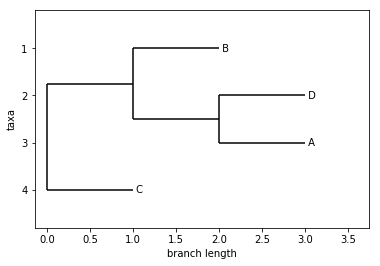

In [124]:
handle = StringIO("((B,(D,A)),C)")
tree = Phylo.read(handle, "newick")
Phylo.draw(tree)

**Exercice 8 :** Implémenter une deuxième version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** (vous pouvez copier-coller la réponse à la question précédente et faire les modifications nécessaires). 

In [41]:
import math
import numpy as np
class UPGMA_Score:
    def __init__(self, d_matrix, keys):
        self.D = d_matrix
        self.keys = []
        self.node2nodeD = {}
        for sp in keys:
            self.keys.append((sp,0.0))
        self.list_D = [(self.D,self.keys)]
    
    def joinD(self,l):
            ret = ''
            if isinstance(l,tuple):
                return l[0]
            for i in l:
                if isinstance(i, list):
                    ret+=","+self.joinD(i)
                elif isinstance(i[0], list):
                    ret+=",{}:{}".format(self.joinD(i[0]),i[1])
                else:
#                     print ("i:",i)
                    ret+=",{}:{}".format(i[0],i[1])
#             print (ret)
            return "({})".format(ret[1:])

    def join(self,l):
            ret = ''
            if isinstance(l,tuple):
                return l[0]
            for i in l:
                if isinstance(i, list):
                    ret+=","+self.join(i)
                elif isinstance(i[0], list):
                    ret+=","+self.join(i[0])
                else:
#                     print ("i:",i)
                    ret+=","+i[0]
#             print (ret)
            return "({})".format(ret[1:])
    
    def getD(self,node):
        if not isinstance(node, list):
                return node[1]
        else:
            return node[1]+self.getD(node)
        
    def composit_nodes(self, node1,node2,d):
        
        if (not isinstance(node1, list)) and (not isinstance(node2, list)):
            return [(node1[0],d/2.),(node2[0],d/2.)]
        elif (not isinstance(node1, list)):
            return [(node1[0],d/2.), (node2, d/2. - self.getD(node2[0])) ]
        elif (not isinstance(node2, list)):
            return [(node1, d/2. - self.getD(node1[0])), (node2[0],d/2.) ]
        return [(node1, d/2. - self.getD(node1[0])) , (node2, d/2. - self.getD(node2[0]))]
    
    def iterate(self,new_d,new_k):
#             print (new_d,new_k)
            if(len(new_d) < 3):
#                 print (" ret: \n",new_k,new_d)
                node = self.composit_nodes(new_k[0],new_k[1],new_d[1,0])
                return node
            keys_to_id = dict(zip([self.join(k) for k in new_k],range(len(new_k))))
            
            min_d, min_d_id = float('inf') ,(0,0)
            for i in range(1,len(new_d)):
                for j in range(0,i):
                    if new_d[i,j] < min_d:
                        min_d, min_d_id = new_d[i,j],(i,j)
            (i,j) = min_d_id
            
#             print (len(new_k),len(new_d))
#             print (new_k)
#             temp_k = [[new_k[i],new_k[j]]] 
            temp_k = [self.composit_nodes(new_k[i],new_k[j],min_d)] 
            temp_k += [new_k[k] for k in range(len(new_k)) if k != i and k != j]
            temp_d = np.zeros((len(temp_k),len(temp_k)),dtype=np.float32)
            
            ni = len(new_k[i][0])
            nj = len(new_k[j][0])
            
            for k in range(1,len(temp_k)):
                k2 = keys_to_id[self.join(temp_k[k])]
                di = (ni*new_d[max(i,k2),min(i,k2)])
                dj = (nj*new_d[max(j,k2), min(j,k2)])
                temp_d[k][0] = (di + dj)/float(ni+nj)
                
#                 print (ni,nj,di,dj)
            for i in range(1,len(temp_k)):
                for j in range(1,i):
                    temp_d[i][j] = new_d[keys_to_id[self.join(temp_k[i])],keys_to_id[self.join(temp_k[j])]]
#             print(temp_k ,"join:", self.join(temp_k))
#             print (temp_k)
#             print (temp_d)
            return  self.iterate(temp_d, temp_k)
        
    def compute(self):
#         print(self.iterate(self.D,self.keys))
        return self.joinD(self.iterate(self.D,self.keys))
        
        

In [148]:
keys = ['A','B','C','D'] 
d_matrix = np.array([[0.0,0.0,0.0,0.0],[2.0,0.0,0.0,0.0],[4.0,6.0,0.0,0.0],[1.0,2.0,4.0,0.0]])
upgma = UPGMA_Score(d_matrix,keys)

In [149]:
upgma.compute()

'((B:1.0,(D:0.5,A:0.5):0.5):1.3333332538604736,C:2.3333332538604736)'

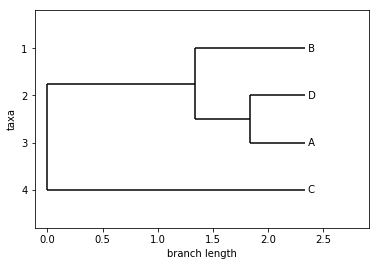

In [152]:
handle = StringIO(upgma.compute())
tree = Phylo.read(handle, "newick")
Phylo.draw(tree)

In [42]:
m,k = distMatrix(fasta_parser('cat_dna.fasta'))
upgma = UPGMA_Score(np.array(m),[i.replace(" ","") for i in k])

In [215]:
k

['Cheetah DNA',
 'Tiger DNA',
 'Sabertooth DNA',
 'Lion DNA',
 'Wolf DNA',
 'Felis Cat A DNA',
 'Leopard DNA',
 'Brown Bear DNA',
 'Spotted Hyena DNA',
 'African wild cat DNA',
 'Puma DNA',
 'Wild Cat DNA',
 'Homotherium DNA',
 'Chinese Desert cat DNA',
 'Black Bear DNA',
 'Cave Bear DNA',
 'Dog DNA',
 'Striped Hyena DNA',
 'American Cat DNA']

In [43]:
upgma.compute()

'(((BlackBearDNA:0.053046539425849915,(BrownBearDNA:0.03345070406794548,CaveBearDNA:0.03345070406794548):0.019595835357904434):0.034867048263549805,(((LeopardDNA:0.03684210404753685,LionDNA:0.03684210404753685):0.019981835037469864,(TigerDNA:0.05520695075392723,((CheetahDNA:0.03873239457607269,(AmericanCatDNA:0.026408450677990913,PumaDNA:0.026408450677990913):0.01232394389808178):0.014096830040216446,(ChineseDesertcatDNA:0.050380513072013855,(FelisCatADNA:0.00812215730547905,(AfricanwildcatDNA:0.005263158120214939,WildCatDNA:0.005263158120214939):0.0028589991852641106):0.042258355766534805):0.002448711544275284):0.041110120713710785):0.001616988331079483):0.05588711425662041,((StripedHyenaDNA:0.05809859186410904,SpottedHyenaDNA:0.05809859186410904):0.01244424283504486,(SabertoothDNA:0.06360424309968948,HomotheriumDNA:0.06360424309968948):0.0069385915994644165):0.06342470645904541):0.03202647343277931):0.05758760869503021,(WolfDNA:0.0,DogDNA:0.0):0.09245465695858002)'

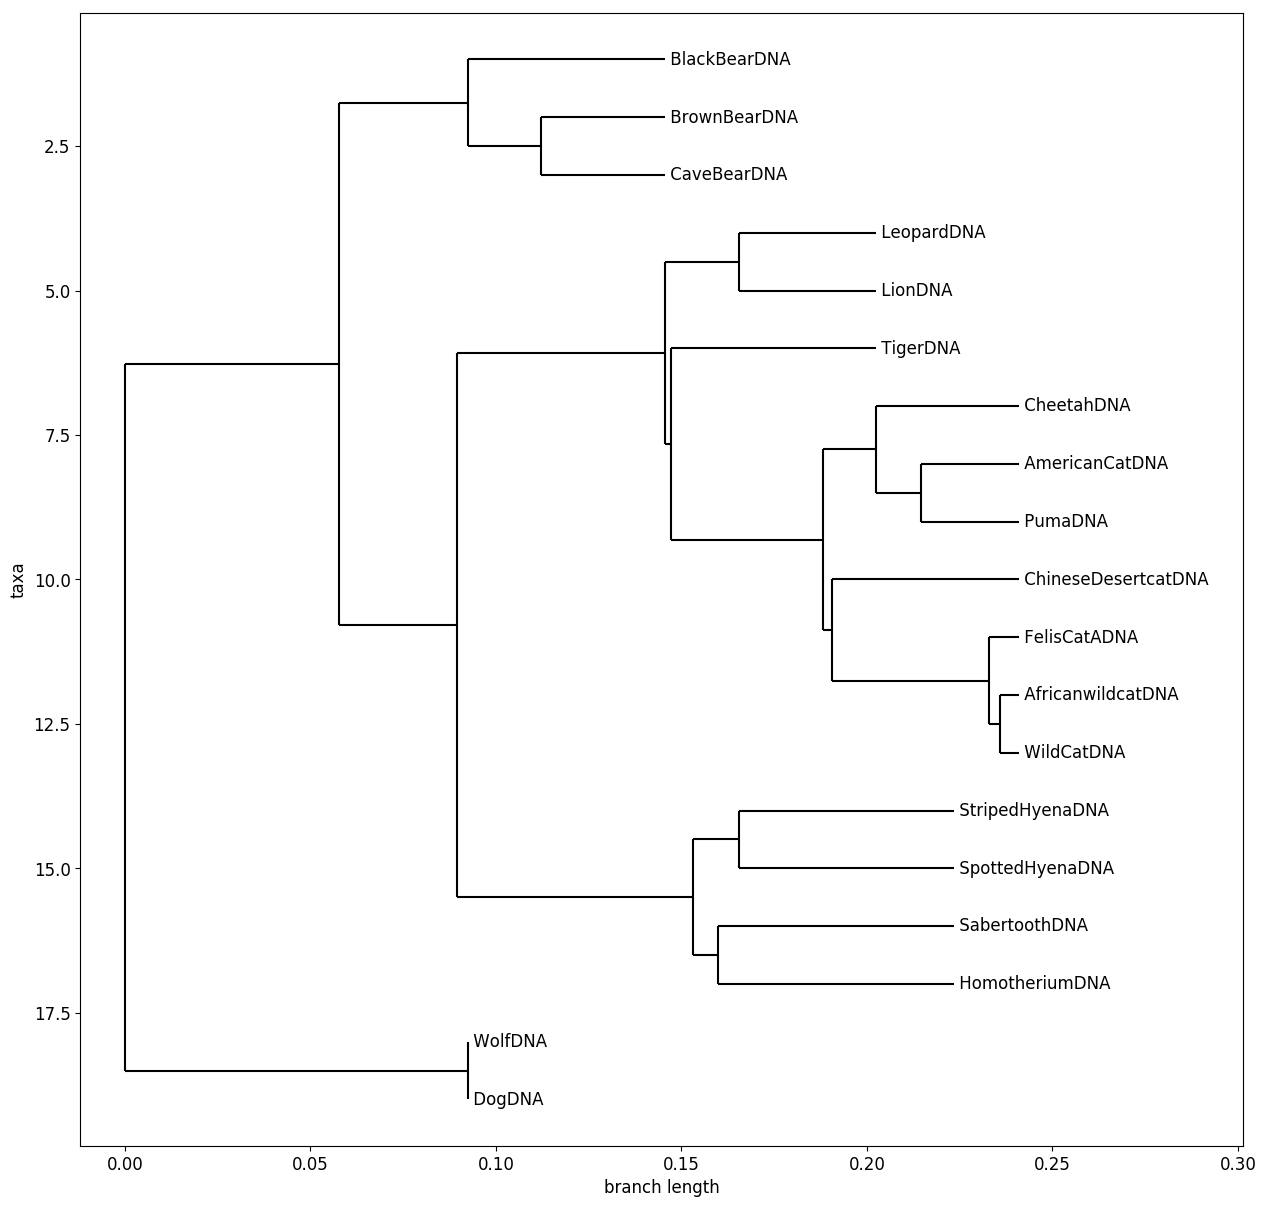

In [44]:
import matplotlib
import matplotlib.pyplot as plt

handle = StringIO(upgma.compute())
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=12)
# set the size of the figure
fig = plt.figure(figsize=(15, 15), dpi=100)
# alternatively
# fig.set_size_inches(10, 20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, do_show=True, show_confidence=True)
# Phylo.draw(tree)

In [50]:
# help(Phylo.draw)

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : Oui, Enracinement avec un groupe exterieur. Oui:

In [32]:
upgma_tree = "(((BlackBearDNA,(BrownBearDNA,CaveBearDNA)),(((LeopardDNA,LionDNA),(TigerDNA,((CheetahDNA,(AmericanCatDNA,PumaDNA)),(ChineseDesertcatDNA,(FelisCatADNA,(AfricanwildcatDNA,WildCatDNA)))))),((StripedHyenaDNA,SpottedHyenaDNA),(SabertoothDNA,HomotheriumDNA)))),(WolfDNA,DogDNA))"

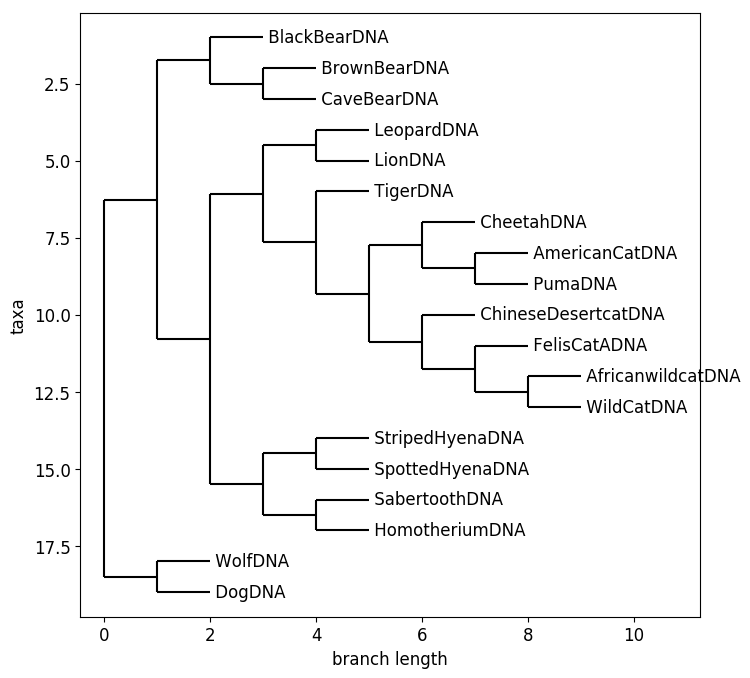

In [46]:
import matplotlib
import matplotlib.pyplot as plt

handle = StringIO(upgma_tree)
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=12)
# set the size of the figure
fig = plt.figure(figsize=(8, 8), dpi=100)
# alternatively
# fig.set_size_inches(10, 20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)
# Phylo.draw(tree)

In [35]:
ext_tree = "(((BlackBearDNA,(BrownBearDNA,CaveBearDNA)),(WolfDNA,DogDNA)),(((LeopardDNA,LionDNA),(TigerDNA,((CheetahDNA,(AmericanCatDNA,PumaDNA)),(ChineseDesertcatDNA,(FelisCatADNA,(AfricanwildcatDNA,WildCatDNA)))))),((StripedHyenaDNA,SpottedHyenaDNA),(SabertoothDNA,HomotheriumDNA))))"

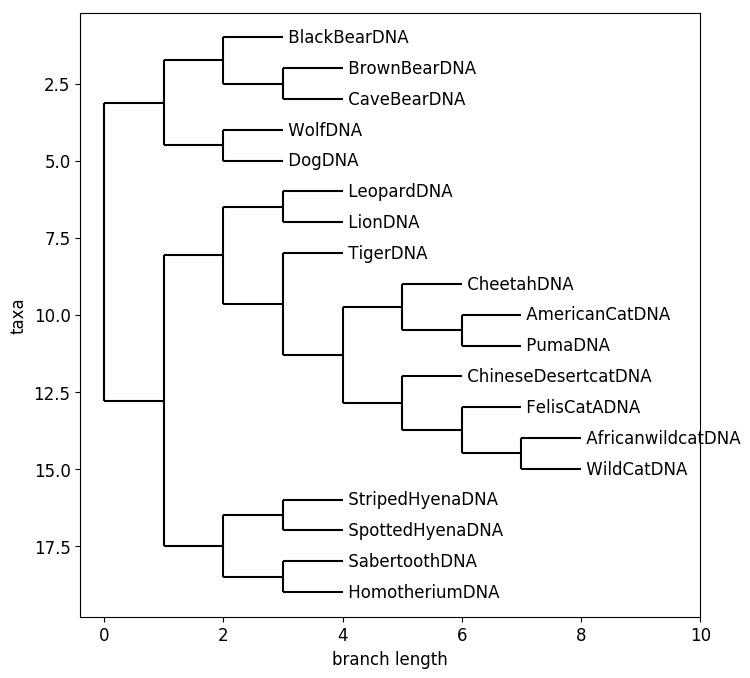

In [45]:
import matplotlib
import matplotlib.pyplot as plt

handle = StringIO(ext_tree)
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=12)
# set the size of the figure
fig = plt.figure(figsize=(8, 8), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 10 :** Calculer le bootstrap des branches de l'arbre précédemment obtenu.

In [99]:
import math
import numpy as np
class UPGMA_Bootstrap:
    def __init__(self, d_matrix, keys):
        self.D = d_matrix
        self.keys = keys
        self.keys_len = {}
        self.banches = {}
        for sp in keys:
            self.keys_len[sp] = 1.
        self.list_D = [(self.D,self.keys)]
    
    def join(self,l):      
        if not isinstance(l, list):
            return l
        ret = ''
        for i in l:
            if isinstance(i, list):
                ret+=","+self.join(i)
            else:
                ret+=","+i
#             print (ret)
        ret = "({})".format(ret[1:])
        return ret
    
    def join_score(self,l):

        if not isinstance(l, list):
            return l
        ret = ''
        for i in l:
            if isinstance(i, list):
                ret+=","+self.join(i)
            else:
                ret+=","+i
#             print (ret)
        ret = "({})".format(ret[1:])
        if not ret in self.banches:
            self.banches[ret] = 0
        return ret
    
    def iterate(self,new_d,new_k):
#             print (new_d,new_k)
        if(len(new_d) < 3):
            return new_d,new_k

        keys_to_id = dict(zip([self.join(k) for k in new_k],range(len(new_k))))

        min_d, min_d_id = float('inf') ,(0,0)
        for i in range(1,len(new_d)):
            for j in range(0,i):
                if new_d[i,j] < min_d:
                    min_d, min_d_id = new_d[i,j],(i,j)
        (i,j) = min_d_id

#             print (len(new_k),len(new_d))
#             print (new_k)
        temp_k = [[new_k[i],new_k[j]]] 
        temp_k += [new_k[k] for k in range(len(new_k)) if k != i and k != j]
        temp_d = np.zeros((len(temp_k),len(temp_k)),dtype=np.float32)

        ni = len(new_k[i])
        nj = len(new_k[j])

        for k in range(1,len(temp_k)):
            k2 = keys_to_id[self.join(temp_k[k])]
            di = (ni*new_d[max(i,k2),min(i,k2)])
            dj = (nj*new_d[max(j,k2), min(j,k2)])
            temp_d[k][0] = (di + dj)/float(ni+nj)

#                 print (ni,nj,di,dj)
        for i in range(1,len(temp_k)):
            for j in range(1,i):
                temp_d[i][j] = new_d[keys_to_id[self.join(temp_k[i])],keys_to_id[self.join(temp_k[j])]]
#             print(self.join(temp_k))
        return  self.iterate(temp_d, temp_k)
    def compute(self):
            return self.iterate(self.D,self.keys)[1]
        
        

In [111]:
upgma = UPGMA_Bootstrap(np.array(m),k)

In [112]:
upgma.compute()

[[['Black Bear DNA', ['Brown Bear DNA', 'Cave Bear DNA']],
  [[['Leopard DNA', 'Lion DNA'],
    ['Tiger DNA',
     [['Cheetah DNA', ['American Cat DNA', 'Puma DNA']],
      ['Chinese Desert cat DNA',
       ['Felis Cat A DNA', ['African wild cat DNA', 'Wild Cat DNA']]]]]],
   [['Striped Hyena DNA', 'Spotted Hyena DNA'],
    ['Sabertooth DNA', 'Homotherium DNA']]]],
 ['Wolf DNA', 'Dog DNA']]

In [308]:
import random
class Bootstrap:
    def __init__(self, data):
        self.data = data
        self.length = len(data[list(data.keys())[0]])
        self.banches = {}
#         m,k = distMatrix(data)
        upgma = UPGMA_Bootstrap(np.array(m),[i.replace(" ","") for i in k])
        self.tree = upgma.compute()
        self.join_score(self.tree , init =True)
        
    def join(self,l):      
        if not isinstance(l, list):
            return l
        ret = ''
        for i in l:
            if isinstance(i, list):
                ret+=","+self.join(i)
            else:
                ret+=","+i
#             print (ret)
        ret = "({})".format(ret[1:])
        return ret
        
    def join_score(self,l,init = False, inc =True):
        if not isinstance(l, list):
            return l
        ret = ''
        for i in l:
            if isinstance(i, list):
                ret+=","+self.join_score(i,init, inc)
            else:
                ret+=","+i
#             print (ret)
        ret = "({})".format(ret[1:])
        if inc:
            if not ret in self.banches:
                if init:
                    self.banches[ret] = 0
                    self.banches[self.join(l[::-1])] = 0
            else:
                self.banches[ret] += 1
        return ret
    
    def join_withscore(self,l,init = False):
        if not isinstance(l, list):
            return l
        ret = ''
        for i in l:
            if isinstance(i, list):
                ret+=","+self.join_withscore(i,init)
            else:
                ret+=","+i
#             print (ret)
        ret = "({})".format(ret[1:])
        key = self.join(l)
        key2 = self.join(l[::-1])
        score = 0
        if key in self.banches:
            score += self.banches[key]
        if key2 in self.banches:
            score += self.banches[key2]
        ret = ret+str(score)
        return ret
    
    def compute(self,n=10):
        ids = [ random.sample(range(self.length),1)[0] for i in range(self.length)]
        for it in range(n):
            ids = [ random.sample(range(self.length),1)[0] for i in range(50)]
#             print ('iteration: ',it,ids)
#             ids = [ random.sample(range(self.length),1)[0] for i in range(self.length)]
            print ('iteration: ',it)
            data_sample = {i:''.join([data[i][j] for j in ids]) for i in data}
            m,k = distMatrix(data_sample)
            upgma = UPGMA_Bootstrap(np.array(m),[i.replace(" ","") for i in k])
            tree = upgma.compute()
            self.join_score(tree,True)

In [281]:
data = fasta_parser('cat_dna_msa_no_gap.fasta')
# [len(data[i]) for i in data]

In [285]:
m,k = distMatrix(data)

In [309]:
bootstrap = Bootstrap(data)

In [311]:
bootstrap.compute(100)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19


In [312]:
bootstrap.join_withscore(bootstrap.tree)

'(((BlackBearDNA,(BrownBearDNA,CaveBearDNA)15)0,(((LeopardDNA,LionDNA)9,(TigerDNA,((CheetahDNA,(AmericanCatDNA,PumaDNA)9)4,(ChineseDesertcatDNA,(FelisCatADNA,(AfricanwildcatDNA,WildCatDNA)15)13)3)0)0)0,((StripedHyenaDNA,SpottedHyenaDNA)4,(SabertoothDNA,HomotheriumDNA)4)0)0)0,(DogDNA,WolfDNA)21)0'

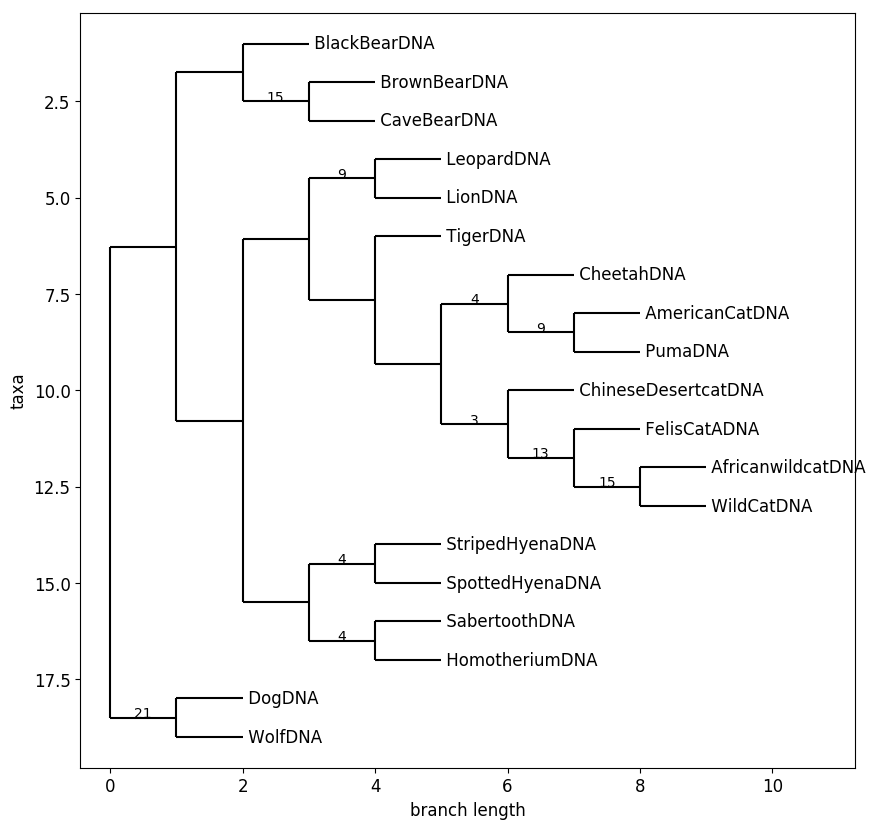

In [313]:
handle = StringIO(bootstrap.join_withscore(bootstrap.tree))
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=12)
# set the size of the figure
fig = plt.figure(figsize=(10, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

In [277]:
bootstrap.join_withscore(bootstrap.tree)

'(((BlackBearDNA,(BrownBearDNA,CaveBearDNA)0)0,(((LeopardDNA,LionDNA)78,(TigerDNA,((CheetahDNA,(AmericanCatDNA,PumaDNA)87)56,(ChineseDesertcatDNA,(FelisCatADNA,(AfricanwildcatDNA,WildCatDNA)76)76)16)5)0)0,((StripedHyenaDNA,SpottedHyenaDNA)53,(SabertoothDNA,HomotheriumDNA)17)2)0)0,(DogDNA,WolfDNA)100)0'

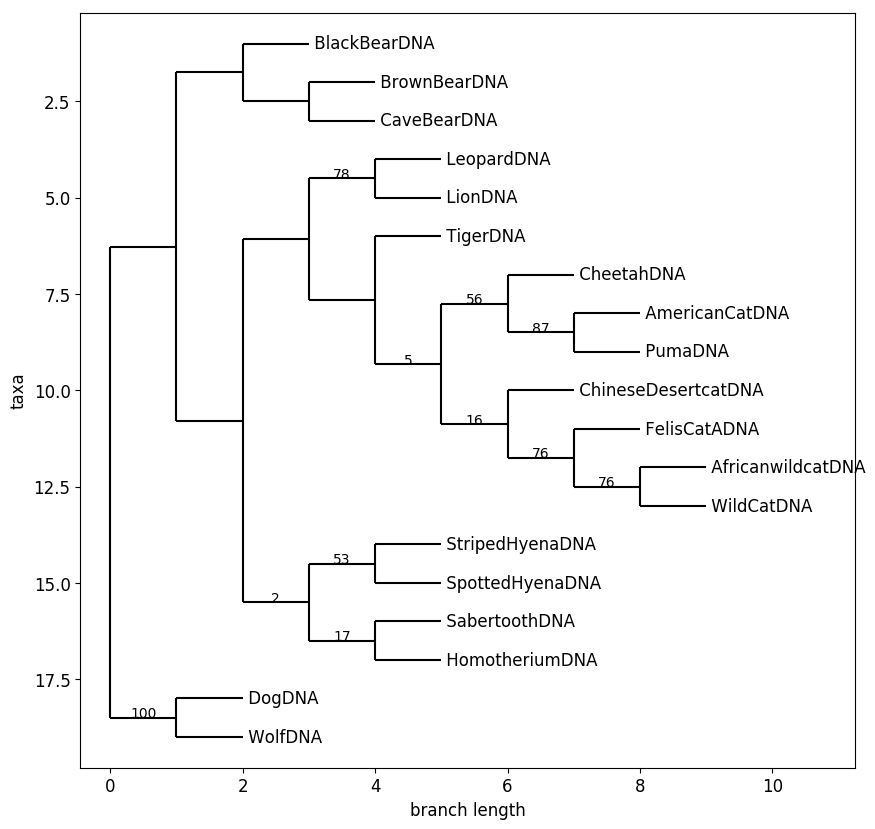

In [278]:
handle = StringIO(bootstrap.join_withscore(bootstrap.tree))
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=12)
# set the size of the figure
fig = plt.figure(figsize=(10, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

----
## Conclusion

**Exercice 11 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ?

Réponse : Il font tous partie de la famille des felins. <br>
Smilodon et Homotherium sont tres probablement des proche cousin, et M. trumani est proche cousin avec le Puma

----
# Partie bonus

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 12 :** Implémenter l'algorithme du neighbor-joining, enraciner l'arbre obtenu avec la méthode apropriée et calculer le boostrap de ses branches.

In [ ]:
# À remplir

----
## Suite de la conclusion

**Exercice 13 :** Quelles différences remarquez-vous avec l'arbre obtenu avec UPGMA ? Comment les expliquer ? Quelles sont vos nouvelles conclusions concernant les similarités entre _smilodon_, _homotherium_ et _M. trumani_ ?

Réponse :